In [6]:
import os
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import re
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans

In [7]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []
    
def get_samples(data_files):

    csps = []
    timestamps = []
    samples = []
    
    for file_path in data_files:
        #if maneuver not in file_path or "speed" in file_path:
            #continue
        #print(file_path)

        # Load data 
        data = pd.read_csv(file_path, sep=";")
        
        csps_tmp =  data["Morton_Index"].to_list()
        csps_tmp = csps_tmp[200:-500]
        timestamps_tmp = data['Time (seconds)'] + data['Time (microseconds)'] / (10**6)
        timestamps_tmp = timestamps_tmp[200:-500]
        end_ind = int(len(csps_tmp) / 2)
        csps = csps + csps_tmp[:end_ind]
        timestamps = timestamps + timestamps_tmp.to_list()[:end_ind]

    
    samples.append(timestamps)
    samples.append(csps)
    return np.array(samples).T


Selecting the files (types, manoeuvres) used for the clustering of the points in the CSPs:

In [8]:
parentFolder = 'results/synthetic_lanechangecitos_morton'
data_files_old = []

for direction in ['lcright', 'lcleft']:
    for maneuver in ['fixedmaxangle', 'fixedspeed']:
        tmp_array = [f'{direction}_{maneuver}_{i}.csv' for i in range(1,6)]
        data_files_old = data_files_old + tmp_array
data_files = [parentFolder + '/' + data_file for data_file in data_files_old]

# THIS SELECTS ALL THE FILES INSTEAD
data_files = get_files_in_folder(parentFolder)
data_files.sort()
data_files.reverse()
n_clusters = 4

X = get_samples(data_files=data_files)
factor= 1
X[:,0] *= factor
clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)       # Fix seed by random_state = (int)
y_pred = clusters.predict(X)
X[:,0] /= factor
print(np.shape(X))


(36000, 2)


In [9]:
labels = clusters.labels_

lower_bounds = []
upper_bounds = []
clabels = []
for k in range(n_clusters):
    indices = [j for j, label in enumerate(clusters.labels_) if label == k]
    tmp_arr = []
    for index in indices:
        tmp_arr.append(X[index, 1])
    clabels.append(k)
    lower_bounds.append(np.min(np.array(tmp_arr)))
    upper_bounds.append(np.max(np.array(tmp_arr)))

bounds = sorted(zip(lower_bounds, upper_bounds, clabels))
print(bounds)

[(np.float64(27607.0), np.float64(31406.0), 1), (np.float64(49489.0), np.float64(51578.0), 0), (np.float64(51664.0), np.float64(52686.0), 2), (np.float64(52691.0), np.float64(55816.0), 3)]


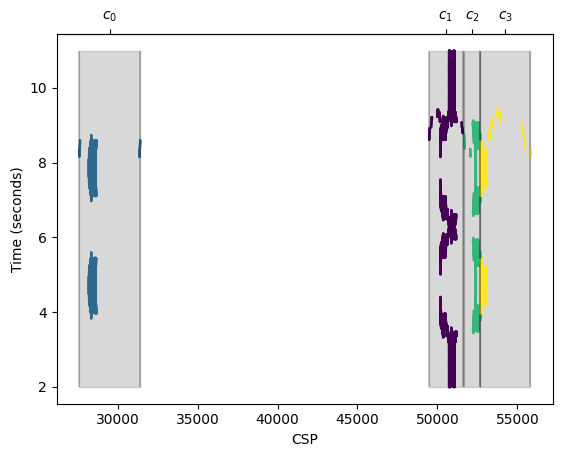

In [10]:

fig, ax = plt.subplots()
for i in range(n_clusters):
    x_min, x_max = bounds[i][0], bounds[i][1]
    y_min, y_max = np.min(X[:,0]), np.max(X[:,0])
    ax.vlines(x=x_min, ymin=y_min, ymax=y_max, lw=0.3, color='black')
    ax.vlines(x=x_max, ymin=y_min, ymax=y_max, lw=0.3, color='black')
    ax.fill_between([x_min, x_max], y_min, y_max,  alpha=0.3, color='grey')

secax = ax.secondary_xaxis('top')
secax.set_xticks(ticks=[(bounds[i][0] + bounds[i][1])/2 for i in range(n_clusters)], labels=[f'$c_{i}$' for i in range(n_clusters)])
ax.scatter(X[:,1], X[:,0], c = y_pred, s=0.5)
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('CSP')
plt.show()

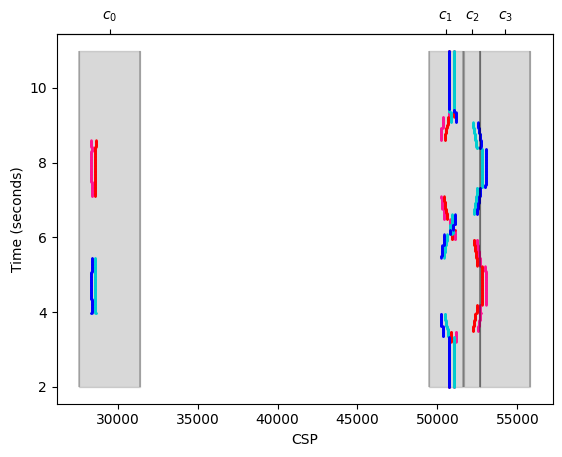

In [11]:
data_files_maneuver = ['results/synthetic_lanechangecitos_morton/lcright_fixedmaxangle_speeddown_3.csv',
                       'results/synthetic_lanechangecitos_morton/lcright_fixedmaxangle_speedup_3.csv',
                       'results/synthetic_lanechangecitos_morton/lcleft_fixedmaxangle_speeddown_3.csv',
                       'results/synthetic_lanechangecitos_morton/lcleft_fixedmaxangle_speedup_3.csv']
color_labels = ['deeppink', 'red', 'darkturquoise', 'blue']

fig, ax = plt.subplots()
for i in range(n_clusters):
    x_min, x_max = bounds[i][0], bounds[i][1]
    y_min, y_max = np.min(X[:,0]), np.max(X[:,0])
    ax.vlines(x=x_min, ymin=y_min, ymax=y_max, lw=0.3, color='black')
    ax.vlines(x=x_max, ymin=y_min, ymax=y_max, lw=0.3, color='black')
    ax.fill_between([x_min, x_max], y_min, y_max,  alpha=0.3, color='grey')

for i,data_file in enumerate(data_files_maneuver[:]):
    X_single = get_samples(data_files=[data_file])
    ax.scatter(X_single[:,1], X_single[:,0], color = color_labels[i], s=0.5, label=data_file)
    
secax = ax.secondary_xaxis('top')
secax.set_xticks(ticks=[(bounds[i][0] + bounds[i][1])/2 for i in range(n_clusters)], labels=[f'$c_{i}$' for i in range(n_clusters)])
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('CSP')

plt.show()

In [12]:
def find_bin_sequence(data_files):   
    
    X_all = get_samples(data_files=data_files)
    lower_bounds, upper_bounds = [], []
    clabels = []
    
    n_clusters = len(np.unique(clusters.labels_))
    for k in range(n_clusters):
        indices = [j for j, label in enumerate(clusters.labels_) if label == k]
        tmp_arr = []
        for index in indices:
            tmp_arr.append(X_all[index, 1])
        clabels.append(k)
        lower_bounds.append(np.min(np.array(tmp_arr)))
        upper_bounds.append(np.max(np.array(tmp_arr)))

    bounds = sorted(zip(lower_bounds, upper_bounds, clabels))
    transform_labels = {}

    for i, el in enumerate(bounds):
        transform_labels[f'{i}'] = el[2]

    res_dict = {}
    for data_file in data_files:
        x_single = get_samples(data_files=[data_file])
        y_single = clusters.predict(x_single)
        bin_sequence = [transform_labels[f'{y_single[0]}']]
        
        for i in range(1, len(y_single)):
            if y_single[i] != y_single[i-1]:
                bin_sequence.append(transform_labels[f'{y_single[i]}'])

        basename = os.path.basename(data_file)
        res_dict[basename] = bin_sequence.copy()
    
    return res_dict

In [16]:
activation_dict = find_bin_sequence(data_files=data_files)

for basename in data_files_maneuver:
    file = basename.split("/")[-1]
    print(file, activation_dict[file])

lcright_fixedmaxangle_speeddown_3.csv [1, 2, 3, 2, 3, 2, 1, 0, 1]
lcright_fixedmaxangle_speedup_3.csv [1, 2, 3, 2, 1, 0, 1]
lcleft_fixedmaxangle_speeddown_3.csv [1, 0, 1, 2, 3, 2, 1]
lcleft_fixedmaxangle_speedup_3.csv [1, 0, 1, 2, 3, 2, 3, 2, 1]
